In [27]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import *
import glob
import scipy 
from datetime import datetime as dt
import sklearn
sns.style = 'darkgrid'

In [36]:
from sklearn.decomposition import PCA

#This function returns a PCA plot from a given dataset of features.
def plot_pca(EMA_df, feature_columns, target_column):
    
    # keep the first two principal components of the data
    features = EMA_df[feature_columns].values
    pca = PCA(n_components=2)
    pg_transformed = pca.fit_transform(features)
    pg_df = pd.DataFrame(data = pg_transformed, columns = ['PC_1', 'PC_2'])
    
    # print relevant results
    print("features: ", feature_columns)
    print("component 1 weights: ", pca.components_[0])
    print("component 2 weights: ", pca.components_[1])
    print("variance explained: ", pca.explained_variance_ratio_)
    
    # make a plot of the principal components
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(pg_transformed[:,0][EMA_df[target_column] == True], 
               pg_transformed[:,1][EMA_df[target_column] == True], 
               label = target_column ,marker ='o')
    
    ax.scatter(pg_transformed[:,0][EMA_df[target_column] == False], 
               pg_transformed[:,1][EMA_df[target_column] == False], 
               label = 'not {}'.format(target_column), marker = 'x')
    
    plt.legend(loc='upper right')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    
    return pg_transformed

In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut, TimeSeriesSplit

#This function returns the feature importance for the Random Forest Classifier Algorithm.
def random_forest_importance(features, target, features_names, plot, cv): 
    
    n_features = features.shape[1]
    # just from some guess and check, it seems that using 500 estimators greatly reduces the random element of the 
    # classifier
    model = RandomForestClassifier(n_estimators = 500)
    model.fit(features, target)
    
    if plot is True: 
        # to determine if the model is better than random chance(i.e. our important features are actually important),
        # we can check with a cross validation score.
        #print('average cross validation score: {:.2f}'.format(cross_val_score(RandomForestClassifier(n_estimators = 500),
        #                                                                      features, target, cv = 3).mean()))
        plot_feature_importance(n_features, features_names, model.feature_importances_)
        
    if cv is True: 
        
        tscv = TimeSeriesSplit(n_splits = 5)
        avg_score = 0
        for train_index, test_index in tscv.split(features): 
            X_train, X_test = features[train_index], features[test_index]
            y_train, y_test = target[train_index], target[test_index]
            
            forest = RandomForestClassifier(n_estimators = 500)
            forest.fit(X_train, y_train)
            score = forest.score(X_test, y_test)
            avg_score += score/5
            
        return avg_score
    
    return model.feature_importances_

In [39]:
#This function returns a plot of the feature importances.
def plot_feature_importance(n_features, features_names, feature_importance): 
    plt.barh(range(n_features), feature_importance, align='center')
    plt.yticks(np.arange(n_features), features_names)
    plt.xlabel('feature importance')

In [40]:
#This function returns and graphs feature importances for a Linear SVC model depending on the features and labels.

from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

def svc_importance(features, target, features_names, plot):
    
    clf = make_pipeline(StandardScaler(), LinearSVC())
    
    clf.fit(features, target)
        
    return clf.named_steps['linearsvc'].coef_
    

In [42]:
#This function returns the location variance.
#Location variance is defined as the log of the sum of the variances of the longitude and latitude.
def location_variance(gps_df):
    
    num =  gps_df['lon'].var() + gps_df['lat'].var()  
    return log(num)

In [44]:
#This function processes PAM data for a given student. 
def process_pam_ema(uid, day = False): 
    
    pam = pd.read_json('dataset/dataset/EMA/response/stress/Stress_' + uid + '.json')
    try: 
        pam['picture_idx'] = pam['picture_idx'].where(np.isfinite, stress.null)
    except: 
        pass
    
    pam['picture_idx'] = pd.to_numeric(pam.level, errors='coerce')
    
    pam = pam[['resp_time', 'picture_idx']]
    pam = pam.dropna()
    
    #pam['level'] = pam['level'].apply(convert_stress)
    if day is True: 
        pam['day'] = pam['resp_time'].dt.dayofyear
        pam = pam.groupby('day').mean()
        # since PAM levels are discrete, we want to take the nearest overall PAM level for the day 
        pam = pam.apply(lambda x: round(x))
        pam['doy'] = pam.index
    
    return pam

In [45]:
def time_in_range(start, end, x):
    """Return true if x is in the range [start, end]"""
    if start <= end:
        return start <= x <= end
    else:
        return start <= x or x <= end

In [46]:
#This function returns average activity inference in a time interval.
def activity_in_range(time_interval, activity_df, func = 'mean'): 
    """    
    Note: the activity dataframe and variable names imply 
    """
    
    # unpack the values from the time interval
    start = time_interval[0]
    end = time_interval[1]
    start_day = time_interval[2]
    end_day = time_interval[3]
    
    # only look at relevant days to say runtime
    if start_day == end_day: 
        activity = activity_df[activity_df['day'] == start_day]
    else: 
        activity = activity_df[activity_df['day'] == start_day].append(activity_df[activity_df['day'] == end_day])
        
    # this try except loop takes care of the case where the activity data is an empty dataframe, so we return Nan 
    try: 
        ### these cases are different for different func inputs so this function can be extensible. 
        
        # in this case, we are looking at activity and taking the mean
        if func == 'mean': 
            return activity[activity['time'].apply(lambda x: time_in_range(start, end, x))][' activity inference'].mean()
        # in this case, we are looking at bluetooth and take the count
        elif func == 'count':
            return activity[activity['time'].apply(lambda x: time_in_range(start, end, x))].shape[0]
        # in this case we apply the location variance function 
        elif func == 'location variance': 
            return location_variance(activity)
    except:
        # if we find none in count, we return 0. If not, there is no data/average from there so return Nan. 
        if func == 'count': 
            return 0
        return np.nan

In [47]:
#This function returns the duration of conversation in an interval.
def conv_range(start, end, conv_interval): 
    
    conv_start = conv_interval[0]
    conv_end = conv_interval[1]
    
    if conv_end < start: 
        return np.nan
    
    elif conv_start > end:
        return np.nan
    
    elif conv_start >= start and conv_end >= end:
        return end - conv_start 
    
    elif conv_start <= start and conv_end <= end:
        return conv_end - start
    
    elif conv_start >= start and conv_end <= end:
        return conv_end - conv_start
    
    elif conv_start <= start and conv_end >= end:
        return end - start

In [48]:
#This function returns conversation duration for a certain time interval.
def conversation_in_range(time_interval, convo_df, start_name, end_name): 

    start = time_interval[0]
    end = time_interval[1]
    start_day = time_interval[2]
    end_day = time_interval[3]
    
    if start_day == end_day: 
        conv = convo_df[convo_df['day'] == start_day]
    else: 
        conv = convo_df[convo_df['day'] == start_day].append(convo_df[convo_df['day'] == end_day])
    
    try:
        conv['interval'] = list(zip(pd.to_datetime(conv[start_name], unit = 's'), 
                                    pd.to_datetime(conv[end_name], unit = 's')))
    except:
        return 0

    
    conv['desired duration'] = conv['interval'].apply(lambda x: conv_range(start, end, x))
    conv = conv.dropna()
    
    return conv['desired duration'].sum()

In [49]:
#This function returns a dataframe with PAM levels and sensor feature values for each PAM response.
#We looked at dataframes with at least 20 data points.
def pam_intervals(uid, window): 
    
    data = process_pam_ema(uid)
    
    # define the window of time we want to look at for each PAM answer. 
    data['start_time'] = data['resp_time'] - pd.to_timedelta(window, unit = 'h')
    data['end_time'] = data['resp_time'] + pd.to_timedelta(window, unit = 'h')
    
    # this will reduce runtime by only looking at sensor data from that day then applying our interval function to it. 
    data['start_day'] = data['start_time'].dt.dayofyear
    data['end_day'] = data['end_time'].dt.dayofyear
    
    # the time interval is just a tuple of (start time, end time)
    # in the future, we will apply functions to the interval using other dataframes to return desired columns inside
    # the interval
    data['interval'] = tuple(zip(data['start_time'], data['end_time'], data['start_day'], data['end_day']))
    
    # load activity data
    activity = pd.read_csv('dataset/dataset/sensing/activity/activity_' + uid + '.csv')
    activity['time'] = pd.to_datetime(activity['timestamp'], unit = 's') 
    activity['day'] = activity['time'].dt.dayofyear
    
    # this will return a column with the average activity inference for the activity dataframe inside each interval. 
    data['activity inf'] = data['interval'].apply(lambda x: activity_in_range(x, activity))
    
    # load conversation data
    conversation = pd.read_csv('dataset/dataset/sensing/conversation/conversation_' + uid + '.csv')
    conversation['convo duration'] = conversation[' end_timestamp'] - conversation['start_timestamp']
    conversation['day'] = pd.to_datetime(conversation['start_timestamp'], unit = 's').dt.dayofyear
    
    # this will return the total conversation duration for each interval
    data['conversation dur'] = data['interval'].apply(lambda x: conversation_in_range(x, conversation, 
                                                                           'start_timestamp', ' end_timestamp'))
    data['conversation dur'] = data['conversation dur'].apply(convert_timedeltas)
    
    # load darkness data
    darkness = pd.read_csv('dataset/dataset/sensing/dark/dark_' + uid + '.csv')
    darkness['day'] = pd.to_datetime(darkness['start'], unit = 's').dt.dayofyear
    darkness['duration'] = darkness['end'] - darkness['start']
    
    # find the total darkness duration for each interval
    data['darkness dur'] = data['interval'].apply(lambda x: conversation_in_range(x, darkness, 'start', 'end'))
    data['darkness dur'] = data['darkness dur'].apply(convert_timedeltas)
    
    # load bluetooth data
    bluetooth = pd.read_csv('dataset/dataset/sensing/bluetooth/bt_' + uid + '.csv')
    bluetooth['time'] = pd.to_datetime(bluetooth['time'], unit = 's')
    bluetooth['day'] = bluetooth['time'].dt.dayofyear
    
    # find the number of bluetooth colocations in each interval. 
    data['bluetooth colocations'] = data['interval'].apply(lambda x: activity_in_range(x, bluetooth, 'count'))
    
    # gps data 
    gps = pd.read_csv('dataset/dataset/sensing/gps/gps_' + uid + '.csv')
    # data is out of order, this will reformat it. 
    gps.reset_index(inplace = True)
    gps.columns = ('timestamp', 'provider', 'network_type', 'accuracy', 'lat',
                   'lon', 'altitude', 'bearing' ,'speed', 'travelstate', 'null')
    gps = gps.drop("null", 1)
    gps['time'] = pd.to_datetime(gps['timestamp'], unit = 's')
    gps['day'] = gps['time'].dt.dayofyear
    
    # find the location variance in each stress interval. 
    data['location variance'] = data['interval'].apply(lambda x: activity_in_range(x, gps, 'location variance'))
    
    # drop Nan values
    data = data.dropna()
    
    # only use these features if we have over 20 datapoints
    if data.shape[0] < 20: 
        return None
    
    # return relevant columns. 
    return data[['picture_idx', 'activity inf', 'conversation dur', 'darkness dur', 'bluetooth colocations', 'location variance']]

In [50]:
pam_intervals('u00', 10)

,picture_idx,activity inf,conversation dur,darkness dur,bluetooth colocations,location variance
8,1.0,0.009639,331.0,17474.0,0,-6.308946
9,4.0,0.145299,23346.0,17123.0,191,-5.667812
10,1.0,0.273995,19053.0,8904.0,79,-5.627031
11,2.0,0.206295,24867.0,13453.0,191,-5.667812
12,2.0,0.206129,24867.0,13453.0,191,-5.667812
...,...,...,...,...,...,...
69,2.0,0.144769,22773.0,4274.0,42,2.446564
70,1.0,0.490304,24770.0,5749.0,64,2.446564
71,1.0,0.182407,25712.0,4274.0,69,2.446564
72,2.0,0.433625,17486.0,4274.0,83,2.380751


In [51]:
#This function converts timedelta values to seconds.
def convert_timedeltas(x): 
    try:
        return x.seconds
    except:
        return x 

In [52]:
#from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

#This function uses permutation importance alongside a time series to return average feature importance for each split as well as the standard deviation.

def perm_importance(features, target, feature_names, plot): 

    tscv = TimeSeriesSplit(n_splits = 5)
    
    avg_importance = np.array([0, 0, 0, 0, 0])
    avg_std = np.array([0, 0, 0, 0, 0])
    
    for train_index, test_index in tscv.split(features): 
            
        X_train, X_test = features[train_index], features[test_index]
        y_train, y_test = target[train_index], target[test_index]
    
        model = RandomForestClassifier()
        model.fit(X_train, y_train)
        
        print(model.score(X_test, y_test))
        
        r = sklearn.inspection.permutation_importance(model, X_test, y_test, n_repeats = 30, random_state = 0)
        
        avg_importance = avg_importance + r.importances_mean/5
        avg_std = avg_std + r.importances_std/5
    
    return avg_importance, avg_std

In [53]:
#This function finds the intervals of stress around the ema response within the window, predicts stress with those sensor data. 
#It returns the feature importance of that stress prediction along with the feature names. 
def feature_importance_intervals(uid, window, plot = False, cv = False): 
    
    data = pam_intervals(uid, window)
    
    
    feature_names = ['activity inf', 'conversation dur', 'darkness dur',
                                 'bluetooth colocations', 'location variance']
    
    features = data[feature_names].values
    
    target = data['picture_idx'].values
    #feat_import = perm_importance(features, target, feature_names, plot) 
    feat_import = random_forest_importance(features, target, feature_names, plot, cv)
    
    return feat_import, feature_names    

In [54]:
feature_importance_intervals('u00', 3, False, True)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(0.32000000000000006,
 ['activity inf',
  'conversation dur',
  'darkness dur',
  'bluetooth colocations',
  'location variance'])

In [55]:
#This function returns the score for all students for a specific window of time
def find_all_cvs(window): 
    
    stress_files = glob.glob('dataset/dataset/EMA/response/PAM/PAM_*.json')
    uid_start = len('dataset/dataset/EMA/response/PAM/PAM_')
    counter = 1
    
    df = pd.DataFrame()
    
    # loops through all the files and averages the feature importance lists
    for file in stress_files: 
        # the uid indexed from the file text
        uid = file[uid_start:uid_start+3]
        
        try: 
            cv = feature_importance_intervals(uid, window, False, True)[0] 
        except: 
            continue
        
        df = df.append(pd.DataFrame({'uid': [uid], 'cv score': [cv]}), ignore_index = True)
        
    return df

In [56]:
cv_dataframe = find_all_cvs(4)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-

In [57]:
#cv_dataframe[cv_dataframe['cv score']>= 0.4]
cv_dataframe.mean()

cv score    0.418314
dtype: float64

In [58]:
#cv_8_dataframe = find_all_cvs(8)

In [59]:
#cv_8_dataframe[cv_dataframe['cv score'] > .4]

In [60]:
#This function loops through all of the windows, ranging from 1 to 10, and returns the scores associated with each window. 
#This function also returns a plot of window duration and the associated model performance.
def find_window_cvs(uid, windows, plot = False): 
    
    df = pd.DataFrame()
    # loop through all the windows
    for i in windows: 
        # this function returns the cross validation of the uid's stress EMA for the given window i
        cv = feature_importance_intervals(uid, i, False, True)[0]
        # add the window and cv score to a dataframe
        df = df.append(pd.DataFrame({'window': i, 'cross validation score': cv}, index = [0]))
    
    # this will make a scatter of the dataframe
    if plot is True: 
        sns.relplot(x='window', y = 'cross validation score', data = df)
    
    # return the row 
    return df #df.iloc[df['cross validation score'].idxmax()]

In [61]:
#This function loops through all of the students to find the window duration associated with their highest cross validation scores.
def optimize_windows(windows): 
    
    returns a dataframe with each uid and its optimal window with cross validation score. 
    
    df = pd.DataFrame()
    
    stress_files = glob.glob('dataset/dataset/EMA/response/PAM/PAM_*.json')
    uid_start = len('dataset/dataset/EMA/response/PAM/PAM_')
    # loops through all the files and averages the feature importance lists
    for file in stress_files: 
        # the uid indexed from the file text
        uid = file[uid_start:uid_start+3]
        # if there aren't enough datapoints, the max_window function will throw an error, so I used a try except loop.
        try: 
            x = find_window_cvs(uid, windows)
        except: 
            continue
        x['uid'] = uid
        max_window = x[x['cross validation score'] == x['cross validation score'].max()]
        df = df.append(max_window, ignore_index = True)
        
#This resultant dataframe has columns indicating the optimal window duration for each student as well as their maximum scores. 
    return df

In [63]:
overall_windows = optimize_windows([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
overall_windows

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-

,window,cross validation score,uid
0,2,0.560000,u24
1,10,0.625000,u32
2,7,0.350000,u49
3,10,0.560000,u08
4,9,0.400000,u45
5,1,0.400000,u12
6,2,0.400000,u12
7,7,0.571429,u04
8,8,0.571429,u04
9,9,0.571429,u04


In [78]:
overall_windows

,window,cross validation score,uid
0,2,0.560000,u24
1,10,0.625000,u32
2,7,0.350000,u49
3,10,0.560000,u08
4,9,0.400000,u45
5,1,0.400000,u12
6,2,0.400000,u12
7,7,0.571429,u04
8,8,0.571429,u04
9,9,0.571429,u04


In [76]:
overall_windows.describe()

,window,cross validation score
count,55.000000,55.000000
mean,5.709091,0.516264
std,3.095234,0.157515
min,1.000000,0.240000
25%,3.000000,0.393333
50%,6.000000,0.525000
75%,8.500000,0.585714
max,10.000000,0.900000


In [79]:
overall_windows.groupby('window')['cross validation score'].count()

window
1     7
2     5
3     4
4     5
5     4
6     6
7     5
8     5
9     6
10    8
Name: cross validation score, dtype: int64

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-

,window,cross validation score
0,1,0.34
0,2,0.28
0,3,0.36
0,4,0.26
0,5,0.24
0,6,0.28
0,7,0.38
0,8,0.32
0,9,0.26
0,10,0.18


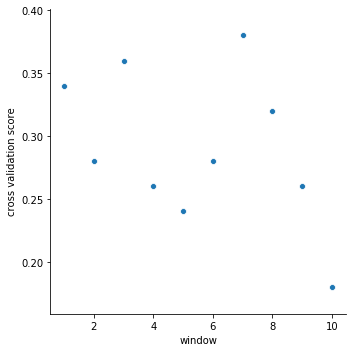

In [69]:
find_window_cvs('u00', [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], plot=True)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-

,window,cross validation score
0,1,0.800000
0,2,0.657143
0,3,0.714286
0,4,0.628571
0,5,0.771429
0,6,0.771429
0,7,0.742857
0,8,0.714286
0,9,0.800000
0,10,0.800000


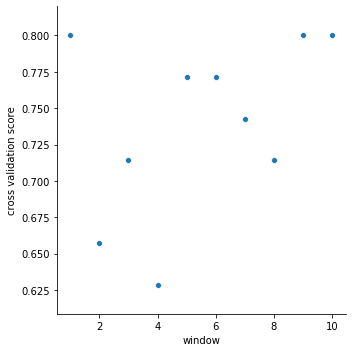

In [72]:
find_window_cvs('u23', [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], plot=True)

In [80]:
#This function returns a new dataframe with all of the activity durations for a particular student throughout the term.
#Only activities longer than 1 minute were considered.
#At the end, we dediced to use total activity duration (sum of activity durations per day) for our model

def activity_analysis(uid):
    activity = pd.read_csv('dataset/dataset/sensing/activity/activity_' + uid + '.csv')
    #Change the path as needed when running the files on your computer.
    activity['day'] = pd.to_datetime(activity['timestamp'], unit = 's').dt.dayofyear
    daily_activity = activity.groupby('day').mean()
    def shift_counter_activity(data):
        shift_num = 0
        list_shift_num = []
        list_time = []
        list_day = []
        for i in range(0, len(data)):
            if data[' activity inference'][i] != 0:
                try: 
                    if data[' activity inference'][i+1] != 0 and (data.index[i]+1) == data.index[i+1]:
                        shift_num += 1
                    else:
                        list_shift_num.append(shift_num)
                        shift_num = 0
                except:
                    list_shift_num.append(shift_num)
                    shift_num = 0
        return list_shift_num
    activity_shifts = shift_counter_activity(activity)
    edited_act = activity[activity[' activity inference'] !=0]
    edited_act = edited_act.reset_index()
    def shifts_only(list1):
        shifts_only_list = []
        for i in list1:
            if i != 0:
                shifts_only_list.append(i)
        return shifts_only_list
    new_activity_shifts = shifts_only(activity_shifts)
    def get_sums(list1):
        list_sums_b = []
        for i in range(0,len(list1)+1):
            new_list = list1[:i]
            sums = sum(new_list)
            list_sums_b.append(sums)
        return list_sums_b
    list_sums_before_activity = get_sums(activity_shifts)
    def activity_dur(list_shift_num, data):
        time_deltas = []
        day = []
        start_time = []
        for i in range(0, len(list_shift_num)):
            if i == 0:
                time_deltas.append(data['timestamp'][list_shift_num[i]] - data['timestamp'][0])
                day.append(data.day[list_shift_num[i]+i+list_sums_before_activity[i]])
                start_time.append(data.timestamp[list_shift_num[i]+i+list_sums_before_activity[i]])
            elif i != 0:
                time_deltas.append(data['timestamp'][list_shift_num[i]+i+list_sums_before_activity[i]] - data['timestamp'][list_sums_before_activity[i]+i])
                day.append(data.day[list_shift_num[i]+i+list_sums_before_activity[i]])
                start_time.append(data.timestamp[list_shift_num[i]+i+list_sums_before_activity[i]])
        dataframe = pd.DataFrame({'Time Delta': time_deltas, 'day': day, 'Start Time': start_time})
        return dataframe
    activity_dur_df = activity_dur(activity_shifts, edited_act)
    activity_dur_df = activity_dur_df[activity_dur_df['Time Delta'] >= 60]
    activity_dur_day = activity_dur_df.groupby('day')['Time Delta'].sum()
    return activity_dur_day

In [81]:
def location_variance(uid):
    gps = pd.read_csv('dataset/dataset/sensing/gps/gps_' + uid + '.csv')
    #gps['time'] = gps['time'].astype('float64')
    gps['time'] = pd.to_datetime(gps.index, unit='s')
    gps['day'] = gps['time'].dt.dayofyear
    lat_var = gps.groupby('day').latitude.var()
    lon_var = gps.groupby('day').longitude.var()
    loc_var = np.log(lat_var + lon_var)
    return loc_var
#location_variance('u00')

In [82]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC
def pam(uid): 
    """
    This function compiles all of the relevant sensor day for our model: 
    Avg. Activity inference, total activity duration (as Time Delta), sleep duration, # of bluetooth colocations, # of unique locations, 
    total darkness duration, conversation duration, and conversation frequency during the day, evening and night epochs.
    """
    pam = pd.read_json('dataset/dataset/EMA/response/PAM/PAM_' + uid + '.json')
    pam = pam.dropna()
    pam['day'] = pam['resp_time'].dt.dayofyear
    pam = pam.groupby('day').mean()
    # since pam levels are discrete, we want to take the nearest overall PAM level for the day 
    pam = pam.apply(lambda x: round(x))
    pam['doy'] = pam.index
    
    # The following code reads the relevant sensor data to compile our features.
    
    activity = pd.read_csv('dataset/dataset/sensing/activity/activity_' + uid + '.csv')
    activity['day'] = pd.to_datetime(activity['timestamp'], unit = 's').dt.dayofyear
    daily_activity = activity.groupby('day').mean()
    
    #To find daily activity, we call the function from the previous cell that finds total activity time per day.
    daily_activity_dur = activity_analysis(uid)
    activity_feat = pd.merge(daily_activity, daily_activity_dur, on='day', how='inner')
    
    conversation = pd.read_csv('dataset/dataset/sensing/conversation/conversation_' + uid + '.csv')
    conversation['day'] = pd.to_datetime(conversation['start_timestamp'], unit = 's').dt.dayofyear
    conversation['start hour'] = pd.to_datetime(conversation['start_timestamp'], unit='s').dt.hour
    conversation['end hour'] = pd.to_datetime(conversation[' end_timestamp'], unit='s').dt.hour
    conversation['convo_duration'] = conversation[' end_timestamp'] - conversation['start_timestamp']
    conversation['epoch'] = list(zip(conversation['start hour'], conversation['end hour']))
    def epoch(times_tuple):        
        start = times_tuple[0]
        end = times_tuple[1]
        
        if (start and end) > 10 and (start and end) <=18:
            return 'Day'
        elif (start and end) >0 and (start and end) <=10:
            return 'Night'
        elif (start and end) >18:
            return 'Evening'
    
    conversation['epoch'] = conversation['epoch'].apply(epoch)
    conversation['day epoch'] = conversation['epoch']=='Day'
    conversation['eve epoch'] = conversation['epoch']=='Evening'
    conversation['night epoch'] = conversation['epoch']=='Night'
    conversation = conversation.replace(False, np.nan)
    conversation_freqs = conversation.groupby('day').count()
    
    
    bluetooth = pd.read_csv('dataset/dataset/sensing/bluetooth/bt_' + uid + '.csv')
    bluetooth['day'] = pd.to_datetime(bluetooth['time'], unit = 's').dt.dayofyear
    bluetooth = bluetooth.groupby('day').count()
    bluetooth['number colocations'] = bluetooth['time']
        
    darkness = pd.read_csv('dataset/dataset/sensing/dark/dark_' + uid + '.csv')
    darkness['day'] = pd.to_datetime(darkness['start'], unit = 's').dt.dayofyear
    darkness['dark duration'] = darkness['end'] - darkness['start']
    darkness = darkness.groupby('day').sum()
    
    wifi_locations = pd.read_csv('dataset/dataset/sensing/wifi_location/wifi_location_' + uid + '.csv')
    wifi_locations.reset_index(inplace = True)
    wifi_locations.columns = ("timestamp", "location", "null")
    wifi_locations = wifi_locations.drop("null", 1)
    wifi_locations['day'] = pd.to_datetime(wifi_locations['timestamp'], unit = 's').dt.dayofyear
    wifi_locations = pd.DataFrame(wifi_locations.groupby('day')['location'].unique())
    wifi_locations['unique locations'] = wifi_locations['location'].apply(lambda x: len(x))
    location_var = location_variance(uid)
    locations_feat = pd.merge(wifi_locations, location_var.rename('location variance'), on='day', how='inner')
    
    features_list = [(activity_feat, ' activity inference'), (activity_feat, 'Time Delta'), (darkness, 'dark duration'), 
                     (bluetooth, 'number colocations'), 
                     (conversation_freqs, 'convo_duration'), (conversation_freqs, 'day epoch'), (conversation_freqs, 'eve epoch'), (conversation_freqs, 'night epoch'), 
                     (locations_feat, 'unique locations'), (locations_feat, 'location variance')]
    
    # The following lines of code combines all of the feature (sensor) and target (PAM) data onto one dataframe.
    data = pam
    for feat in features_list: 
        #print(data.shape)
        data = data.merge(feat[0][[feat[1]]], 
                                left_on = 'doy', right_on = 'day', how = 'inner')
        
    
    features_names = [' activity inference', 'Time Delta', 'dark duration',
                     'number colocations', "convo_duration", 'day epoch', 'eve epoch', 'night epoch', 'unique locations', 'location variance']
    features = data[features_names].values
    
    target = data['picture_idx'].values
    
    
    #The following line of code returns a plot of the feature importances by calling a previous function.
    feat_import = model_importance(RandomForestClassifier(n_estimators=500), features, target, features_names)
    
    return feat_import, features_names


In [83]:
#This function returns the feature importances for all students.
def compile_feat_imports(): 

    pam_files = glob.glob('dataset/dataset/EMA/response/PAM/PAM_*.json')
    uid_start = len('dataset/dataset/EMA/response/PAM/PAM_')
    counter = 1
    # loops through all the files and averages the feature importance lists
    for file in pam_files: 
        # the uid indexed from the file text
        uid = file[uid_start:uid_start+3]
        
        try:
            # Importane is obtained from the previous feature importance function (labeled as pam)
            importance = pam(uid)
        except: 
            # in the case there was no data in the user's ema file,  we skip that user. 
            continue 
        
        if importance is None:
            continue 
        
        if counter == 1: 
            uid_feature_importance = pam(uid)[0]
        else: 
            uid_feature_importance = (uid_feature_importance*(counter - 1) + pam(uid)[0])/counter
        counter += 1
        
    return uid_feature_importance

In [84]:
# This function orders and sorts the sensor data.
def order(feat_imp, sensors): 
    """
    inputs: feat_imp -- array containing the importance of each sensor
            sensors -- the sensor corresponding to each element in the array
    """
    # sort from least to greatest
    sorty = np.sort(feat_imp)
    
    # make a dictionary where the key is the feature importance and the value is the sensor 
    # im making the assumption that no two keys will be the same since there are not many sensors and 
    # accuracy is to many decimals. 
    sorty_dict = {}
    for i in range(len(feat_imp)): 
        sorty_dict[feat_imp[i]] = sensors[i]
    
    # make a sorted sensors list using the dictionary
    sorted_sensors = []
    for elem in sorty: 
        sorted_sensors.append(sorty_dict[elem])
    
    # reverse so the order is most important to least important sensor
    sorted_sensors.reverse()
    
    return sorted_sensors

In [85]:
#This function ranks feature data for each student with respect to predicting their PAM values.
#The rankings are returned as a dictionary.
def rankings():
    pam_files = glob.glob('dataset/dataset/EMA/response/PAM/PAM_*.json')
    uid_start = len('dataset/dataset/EMA/response/PAM/PAM_')
    counter = 1
    # this dictionary will keep track of the most important sensor for each user. 
    most_imp_dict = {}
    # loops through all the files and averages the feature importance lists
    for file in pam_files: 
        # the uid indexed from the file text
        uid = file[uid_start:uid_start+3]
        # find feature importance
        try:
            res = pam(uid)
        except:
        #print(uid)
            continue
        if res is None: 
            continue
        feat_imp = res[0]
        sensors = res[1]
        # reorder the features here
        most_imp_dict[uid] = order(feat_imp, sensors)
    return most_imp_dict

In [86]:
rankings = rankings()

In [87]:
#Using sensor ranking data, this function returns histogram plots to show the distribution of feature importances.
def plot_ranking(sensor_rankings): 
    
    rank_df = pd.DataFrame(rankings)
    # Since the original rank_df has rankings as rows and students as columns, we take the transpose.
    #The transpose dataframe will have rankings as columns and uids as each row.
    rank_df = rank_df.transpose()
    
    # make the plot with two subplot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (40, 10)) 
    # first subplot
    #This subplot returns a plot of the distribution of feature importances:
        #Returns how many students have a particular feature as their most important feature.
    ax1.hist(rank_df[0], rwidth = 0.6)
    ax1.set_ylabel('number of users')
    ax1.set_title('most important sensor for predicting daily PAM (by user)')
    
    # second subplot
    #This subplot returns a plot of the distribution of least important features:
        #Returns the amount of students for whom a particular feature is the least important.
    ax2.hist(rank_df[8], rwidth=0.6)
    ax2.set_ylabel('number of users')
    ax2.xaxis.label.set_fontsize(15)
    ax2.set_title('least important sensor for predicting daily PAM (by user)')
    
    for label in ax1.get_xticklabels() + ax2.get_xticklabels():
        label.set_fontsize(12)
        
    for label in ax1.get_yticklabels() + ax2.get_yticklabels():
        label.set_fontsize(15)
    
    rank_df.columns = ['first', 'second', 'third', 'fourth', 'fifth', 'sixth', 'seventh', 'eighth', 'ninth', 'tenth']
    
    return rank_df

In [88]:
# All the following survey processing code is adapted from the notebook "Survey Dataset V2" 
# This is adapted from another student's code.

# This function processes perceived stress scale (pre and post) surveys 

def pss_analysis(pss_survey):
    """
    Consolidates the  block of code necessary to generate the PSS survey visualizations for
    added modularity of notebook. Running it on the raw PSS data prepares the graphs related
    to this piece of the dataset.
    
    @param: pss_survey – raw data for PSS survey, obtained by using pandas' read_csv method
    
    returns: returns remodeled dataframes for the pre- and post-study halves of the original dataframe
             as a tuple for integrated visualizations with other studies. 
             Prepares graphs for PSS survey visualization.
             plt.show() should be run outside of function call for visualization
    """
    pre_pss = pss_survey[pss_survey.type == 'pre'].drop('type', axis=1)
    post_pss = pss_survey[pss_survey.type == 'post'].drop('type', axis=1)

    def remodel_columns_pss(data):
        """
        Replaces the wordy columns for indices q1-q10. Since PSS
        is standardized, all questions follow the same order and
        can be referred to by indices for simplification.

        @param: data – dataframe containing PSS survey data

        returns: modified dataframe with q1-q10 indexed columns
        """
        index_dict = {}
        for ind in range(data.shape[1]):
            index_dict[data.columns[ind]] = f"q{ind + 1}"

        data = data.rename(columns=index_dict)
        return data


    def numerify_data_pss(entry):
        """
        Replaces string response for corresponding value 0-4.

        @param: dataframe entry containing PSS survey answer

        returns: value 0-4 replacing str answer
           """
        if entry == 'Never':
            return 0
        if entry == 'Almost never':
            return 1
        if entry == 'Sometime':
            return 2
        if entry == 'Fairly often':
            return 3
        if entry == 'Very often':
            return 4
        return entry

    def remodel_data_pss(data):
        """
        Combines functionalities of remodel_columns_pss and numerify_data_pss
        for each entry, offering a dataframe more suitable for analysis. Also
        adds the test score for each student as a new column.

        @param: data – dataframe containing PSS survey data

        returns: modified dataframe with q1-q10 indexed columns and values 0-4
        replacing original str answers in q1-q10, with new columns 'score'
        with each student's test score
        """
        data = remodel_columns_pss(data)
        data = data.applymap(numerify_data_pss)
        # Reverse scoring for particular questions
        for question in {'q4', 'q5', 'q7', 'q8'}:
            data[question] = data[question].apply(lambda x: 4 - x)
        data['score'] = data.sum(axis=1, numeric_only=True)
        data['id'] = data.index
        return data

    pre_pss_m = remodel_data_pss(pre_pss)
    post_pss_m = remodel_data_pss(post_pss)

    return pre_pss_m, post_pss_m

In [89]:
# All the following loneliness survey processing code is adapted from the notebook "Survey Dataset V2" 
# This is adapted from another student's code.

# This function processes loneliness scale (pre and post) surveys 

def lonely_analysis(lonely):
    """
    Consolidates the  block of code necessary to generate the Loneliness survey visualizations for
    added modularity of notebook. Running it on the raw Loneliness data prepares the graphs related
    to this piece of the dataset.
    
    @param: lonely – raw data for Loneliness survey, obtained by using pandas' read_csv method
    
    returns: returns remodeled dataframes for the pre- and post-study halves of the original dataframe
             as a tuple for integrated visualizations with other studies. 
             Prepares graphs for Loneliness survey visualization.
             plt.show() should be run outside of function call for visualization
    """
    pre_lonely = lonely[lonely.type == 'pre'].drop('type', axis=1)
    post_lonely = lonely[lonely.type == 'post'].drop('type', axis=1)

    def remodel_columns_lonely(data):
        """
        Replaces the wordy columns for indices q1-q20. Since LonelinessScale
        is standardized, all questions follow the same order and
        can be referred to by indices for simplification.

        @param: data – dataframe containing PSS survey data

        returns: modified dataframe with q1-q20 indexed columns
        """
        index_dict = {}
        for ind in range(data.shape[1]):
            index_dict[data.columns[ind]] = f"q{ind + 1}"

        data = data.rename(columns=index_dict)
        return data


    def numerify_data_lonely(entry):
        """
        Replaces string response for corresponding value 1-4.

        @param: dataframe entry containing LonelinessScale survey answer

        returns: value 1-4 replacing str answer
        """
        if entry == 'Never':
            return 1
        if entry == 'Rarely':
            return 2
        if entry == 'Sometimes':
            return 3
        if entry == 'Often':
            return 4
        return entry

    def remodel_data_lonely(data):
        """
        Combines functionalities of remodel_columns_lonely and numerify_data_lonely
        for each entry, offering a dataframe more suitable for analysis. Also
        adds the test score for each student as a new column.

        @param: data – dataframe containing PSS survey data

        returns: modified dataframe with q1-q20 indexed columns and values 1-4
        replacing original str answers in q1-q20, with new column 'score'
        with each student's test score
        """
        data = remodel_columns_lonely(data)
        data = data.applymap(numerify_data_lonely)
        for question in {'q1', 'q5', 'q6', 'q9', 'q10',
                         'q15', 'q16', 'q19', 'q20'}:
            data[question] = data[question].apply(lambda x: 5 - x)
        data['score'] = data.sum(axis=1, numeric_only=True)
        data['id'] = data.index
        return data

    pre_lonely_m = remodel_data_lonely(pre_lonely)
    post_lonely_m = remodel_data_lonely(post_lonely)
    
    return pre_lonely_m, post_lonely_m

In [90]:
# This function is modeled off of another student's survey anaylsis code as shown above.
# This function returns processed PHQ-9 survey (pre and post) results.
def depression_analysis(phq9):
    """
    Consolidates the  block of code necessary to generate the Loneliness survey visualizations for
    added modularity of notebook. Running it on the raw Loneliness data prepares the graphs related
    to this piece of the dataset.
    
    @param: lonely – raw data for Loneliness survey, obtained by using pandas' read_csv method
    
    returns: returns remodeled dataframes for the pre- and post-study halves of the original dataframe
             as a tuple for integrated visualizations with other studies. 
             Prepares graphs for Loneliness survey visualization.
             plt.show() should be run outside of function call for visualization
    """
    pre_phq9 = phq9[phq9.type == 'pre'].drop('type', axis=1)
    post_phq9 = phq9[phq9.type == 'post'].drop('type', axis=1)

    def remodel_columns_phq9(data):
        index_dict = {}
        for ind in range(data.shape[1]):
            index_dict[data.columns[ind]] = f"q{ind + 1}"

        data = data.rename(columns=index_dict)
        return data


    def score(response):
        if response == 'Not at all':
            return 0
        elif response == 'More than half the days':
            return 2
        elif response == 'Several days':
            return 1
        elif response == 'Nearly every day':
            return 3
        else:
            return response

    def remodel_data_phq9(data):
        """
        Combines functionalities of remodel_columns_lonely and numerify_data_lonely
        for each entry, offering a dataframe more suitable for analysis. Also
        adds the test score for each student as a new column.

        @param: data – dataframe containing PSS survey data

        returns: modified dataframe with q1-q20 indexed columns and values 1-4
        replacing original str answers in q1-q20, with new column 'score'
        with each student's test score
        """
        data = remodel_columns_phq9(data)
        data = data.applymap(score)
        data['score'] = data.sum(axis=1, numeric_only=True)
        data['id'] = data.index
        return data

    pre_phq9_m = remodel_data_phq9(pre_phq9)
    post_phq9_m = remodel_data_phq9(post_phq9)
    
    return pre_phq9_m, post_phq9_m

In [95]:
#This function plots the feature importance distribution.
def compile_clustering_features(): 

    rankings_df = plot_ranking(rankings)
    rankings_df['id'] = rankings_df.index
    
    pss = pd.read_csv("dataset/dataset/survey/PerceivedStressScale.csv", index_col=0)
    pss_pre, pss_post = pss_analysis(pss)
    
    loneliness = pd.read_csv("dataset/dataset/survey/LonelinessScale.csv", index_col=0)
    loneliness_pre, loneliness_post = lonely_analysis(loneliness)
    
    phq = pd.read_csv("dataset/dataset/survey/PHQ-9.csv", index_col=0)
    phq9_pre, phq9_post = depression_analysis(phq)
    
    
    survey_list = [(pss_pre, 'pss'), (loneliness_pre, 'loneliness'), (phq9_post, 'phq')]
    
    features_df = rankings_df    
    
    for survey in survey_list:     
        features_df = features_df.merge(survey[0][['score', 'id']], on = 'id', how = 'inner')
        features_df = features_df.rename(columns = {'score': survey[1] + ' score'})
    
    return features_df

KeyError: 0

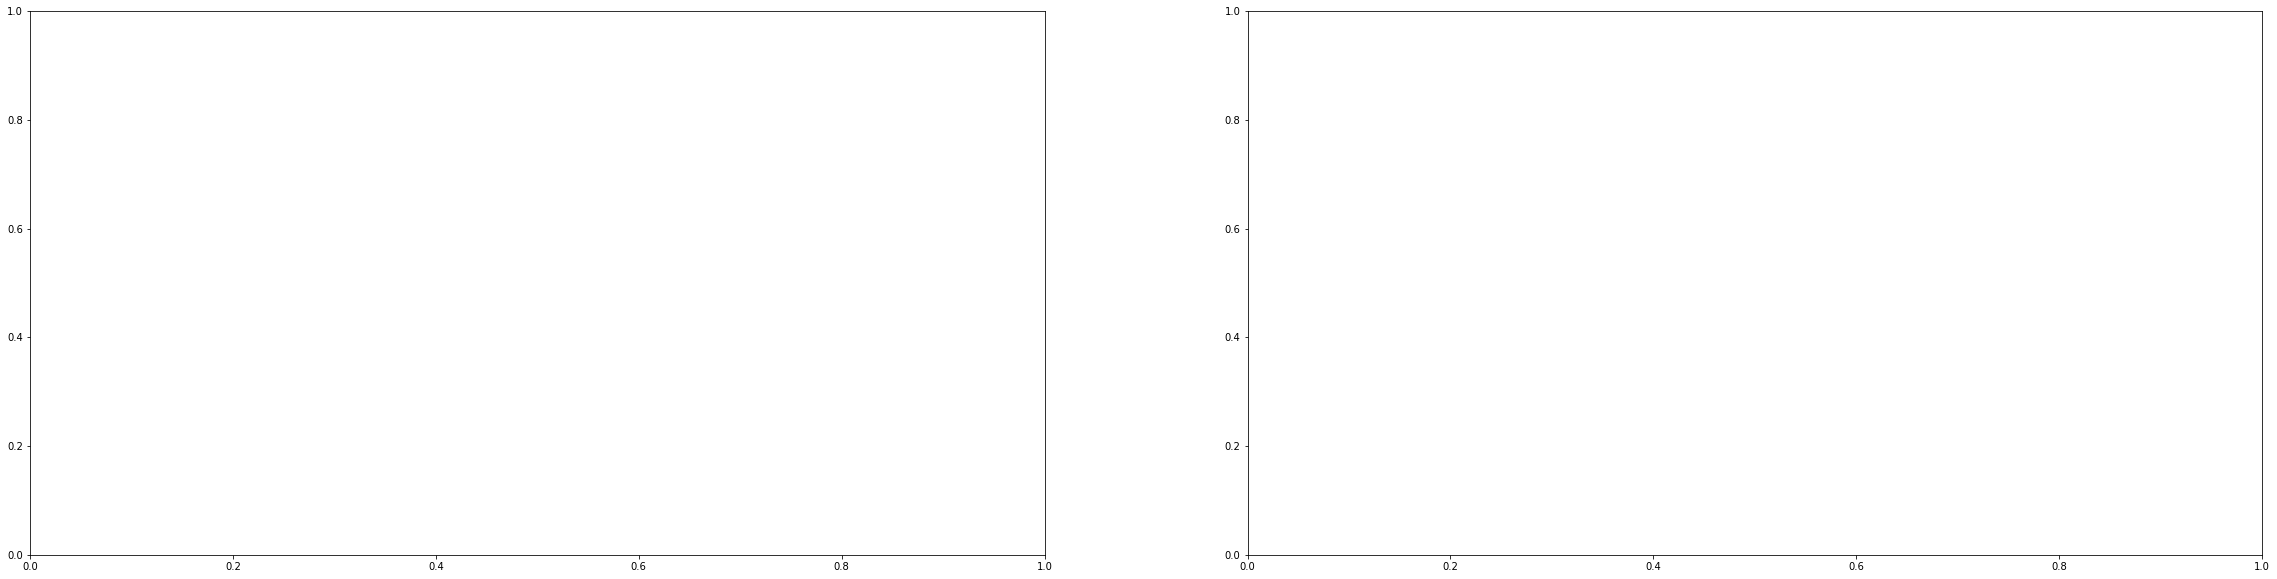

In [96]:
compiled_features = compile_clustering_features()

In [92]:
from sklearn.cluster import AgglomerativeClustering

def importance_clustering(compiled_features, n_clusters, desired_columns): 
    """
    inputs: compiled_features containing survey scores and sensor rankings. 
    
    this function performs agglomerative clustering with 4 groups. 
    """
    
    clustering = AgglomerativeClustering(n_clusters = n_clusters)
    
    features = compiled_features[desired_columns].values
    
    clustering.fit(features)
    
    compiled_features['cluster'] = clustering.labels_
    
    return compiled_features

In [93]:
clusters = importance_clustering(compiled_features, 2, ['loneliness score', 'phq score'])

NameError: name 'compiled_features' is not defined

In [ ]:
c_0 = clusters[clusters.cluster == 0]

In [ ]:
c_1 = clusters[clusters.cluster == 1]

In [ ]:
x = c_0[['first', 'loneliness score', 'phq score']]

In [ ]:
def plot_ranking_clusters(clustered_df, desired_columns, n_clusters): 
    """
    input: 
        clustered_df -- containing rankings and clusters for each user id
        desired_columns -- features we want to plot
        n_cluster -- number of clusters
        
    first plots the clusters on the desired_columns axes
    """
    
    ### plot clusters on desired axes
    ax = plt.subplot(111)
    
    for i in range(n_clusters): 
        # plot each individual cluster
        cluster = clustered_df[clustered_df['cluster'] == i]
        ax.scatter(x=cluster[desired_columns[0]], y=cluster[desired_columns[1]], label = 'cluster {}'.format(i))

        
    plt.legend()
    plt.ylabel(desired_columns[1])
    plt.xlabel(desired_columns[0])
    plt.title(desired_columns[0] + ' ' + desired_columns[1] + ' clustering')
    
    
    ### make a histogram of the most important features in each cluster   
    
    plt.figure(figsize = (10, 6))
    sns.countplot(x = 'first', hue = 'cluster', data = clustered_df)

    plt.ylabel('number of users')
    plt.title('most important sensor per cluster')
    plt.figure()
    
     ### make a histogram of the least important features in each cluster  
    
    plt.figure(figsize = (10, 6))
    sns.countplot(x = 'eighth', hue = 'cluster', data = clustered_df)

    plt.ylabel('number of users')
    plt.title('least important sensor per cluster')
    plt.figure()

In [ ]:
def combined_clustering(n_clusters, desired_columns): 
    """
    inputs: n_clusters -- number of clusters desired
            desired_columns -- labels of survey columns we want to plot
            
    forms the feature importance ranking data into the number of clusters and plots them on the desired_columns axes.
    Also produces histograms showing the feature importance of each cluster. 
    """
    compiled_features = compile_clustering_features()
    clusters = importance_clustering(compiled_features, n_clusters, desired_columns)
    plt.figure(figsize=(10,6))
    plot_ranking_clusters(clusters, desired_columns, n_clusters)

In [ ]:
#combined_clustering(2, ['loneliness score', 'phq score'])